In [3]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2

In [4]:
image = cv2.imread("images/rubik.jpg")

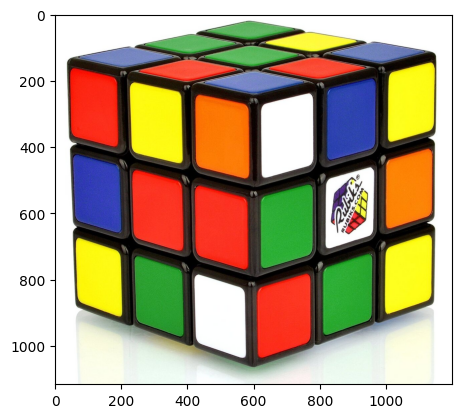

In [8]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [11]:
image = cv2.imread("images/checkboard0.jpeg")
image.shape

(191, 264, 3)

# Detect checkboard corners

To estimate homography (sub-pixel precision), we need at least four correspondences between 3D points lying on the checkerboard and 2D points in the image. To detect the corners, we have to use `findChessboardCorners`

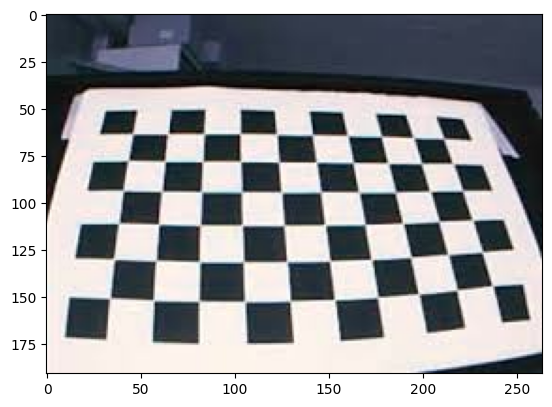

In [13]:
plt.imshow(image)

In [21]:
grid_size = (6, 10) # number of corners (borders of black and white squares that touch)

return_value, corners = cv2.findChessboardCorners(image, patternSize=grid_size)
return_value

True

In [22]:
print(corners[:2])
print(corners.shape)

[[[211.50162  66.11203]]

 [[216.35503  79.42359]]]
(60, 1, 2)


In [23]:
corners = corners.reshape((60,2)).copy() # let's reshape the corners so we can use them in a better way
corners[-1,:]

array([ 33.908005, 150.94814 ], dtype=float32)

In [24]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# FindChessboardCorners is approximate, to get sub-pixel precision, we have to use a function which requires the grayscale image

# Tuple to specify the termination criteria of the iterative refinement algorithm
criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 100, 0.001)

cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
corners[-1,:]

array([ 33.795353, 150.94173 ], dtype=float32)

The values are slightly different and this is needed to have precise results

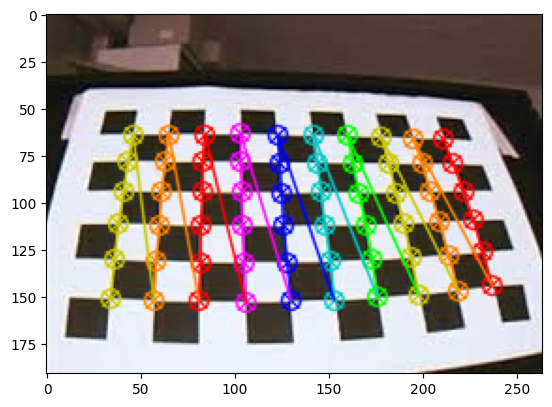

In [25]:
# let's draw the corners, this function is also going to tell us the order in which they were discovered

image_copy = image.copy()
cv2.drawChessboardCorners(image_copy, grid_size, corners, return_value)
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

The origin is the red point on the top right. This is the same order we have to provide the real-world coordinates in the plane for the corresponding points.

# Establishing correspondences

Since each grid has a height and width of 11mm.
We know that 

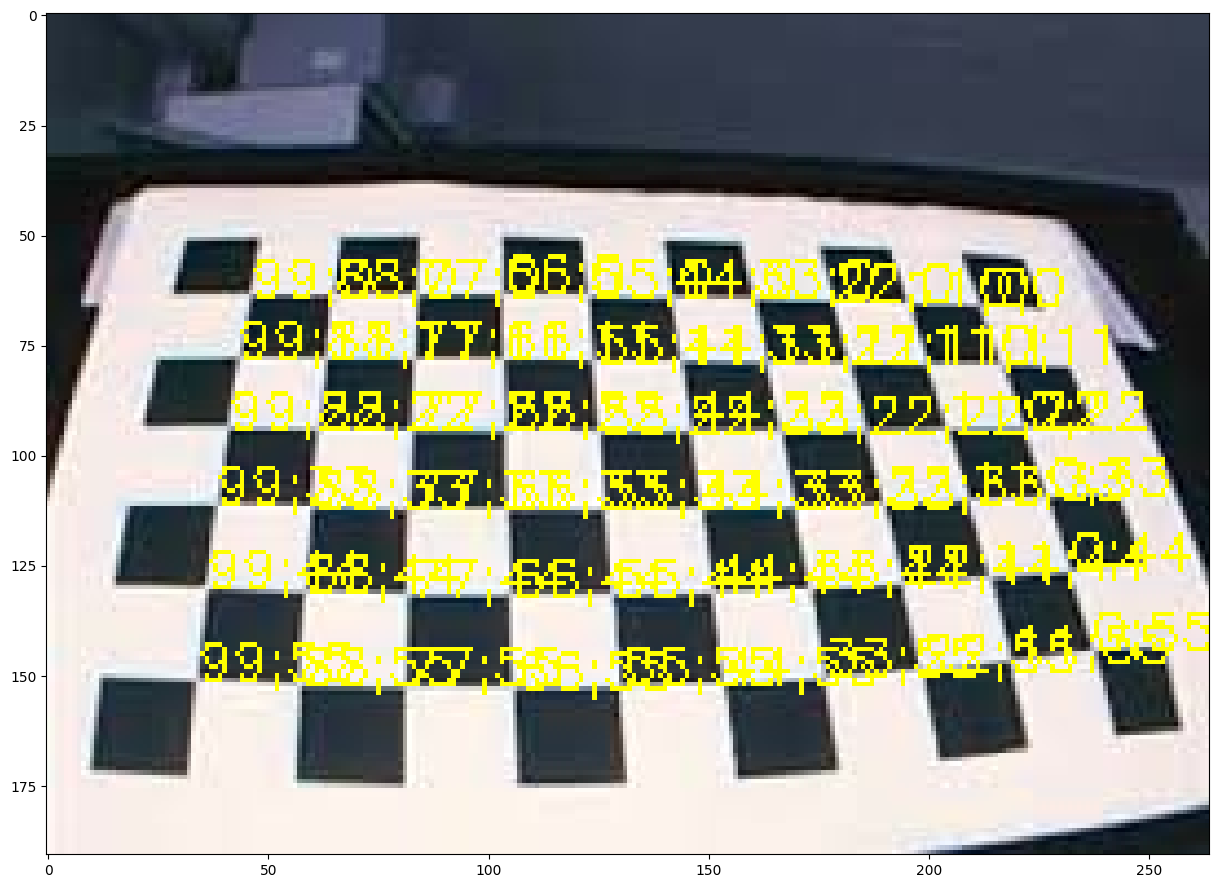

In [26]:
square_size = 11 # mm

another_copy = image.copy()

real_coordinates = np.empty_like(corners)

for index, corner in enumerate(corners):
    u_coord = corner[0]
    v_coord = corner[1]

    # unravel_index converts an index from linear to 2d
    # example: index 7 of a 3x4 matrix corresponds to position (1, 3) of the matrix
    # notice that we revert the grid size as 2d matrices are stored differently in Python and OpenCV backend
    grid_size_cv2 = tuple(reversed(grid_size))
    u_index, v_index = np.unravel_index(index, grid_size_cv2)

    # This is the distance of the corner wrt the reference corner (upper left) at position (0,0)
    u_mm = (u_index) * square_size
    v_mm = (v_index) * square_size

    # we store them in the real_coordinates array
    real_coordinates[index,:] = [u_mm, v_mm]

    # This superimposes the text to the image
    cv2.putText(another_copy, text=f"{u_mm};{v_mm}", org=(round(u_coord), round(v_coord)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=.4, color=(255,255,0))

plt.figure(figsize=(15, 15))
plt.imshow(another_copy)

In [ ]:
# corners px     real coords mm
# u0 v0      <-> x0 y0 0 0

# We want to solve: Ah = b

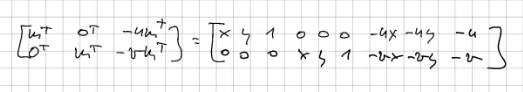

In [28]:
A = np.empty((0,9), dtype=float)
b = np.empty((0,1), dtype=float)

for index, corner in enumerate(corners):
    Xpixel = corners[index, 0]
    Ypixel = corners[index, 1]
    Xmm = real_coordinates[index, 0]
    Ymm = real_coordinates[index, 1]

    m = np.array([Xmm, Ymm, 1]).reshape(1, 3)
    O = np.array([0,0,0]).reshape(1, 3)

    # Construct A and b
    A = np.vstack((A, np.hstack((m, O, -Xpixel * m))))
    A = np.vstack((A, np.hstack((O, m, -Ypixel * m))))
    b = np.vstack((b, np.array([[0], [0]])))

In [ ]:
print(np.linalg.matrix_rank(A))

U, S, Vh = np.linalg.svd(A) # Singular value decomposition

np.linalg.norm(A - U[:,:9]@np.diag(S)@Vh)

9


4.102438045984191e-11

In [ ]:
h=Vh.transpose()[:,-1] # keep the last column of V (pay attention to the transposition)
print(h)
H = h.reshape(3,3) # pay attention to the ordering of the elements (column-wise, row-wise)
H # this is the estimated homography

[ 7.81485148e-03  1.42676380e-03 -9.55527408e-01  3.74175931e-04
 -4.43646347e-03 -2.94727393e-01  4.00382631e-06  1.51853208e-05
 -4.49521994e-03]


array([[ 7.81485148e-03,  1.42676380e-03, -9.55527408e-01],
       [ 3.74175931e-04, -4.43646347e-03, -2.94727393e-01],
       [ 4.00382631e-06,  1.51853208e-05, -4.49521994e-03]])

# Superimpose a rectangle on the checkerboard